## Importando bibliotecas e módulos necessários

In [1]:
import re
import string

from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# Configuração de exibição do DataFrame no pandas
pd.set_option('display.max_colwidth', None) # exibe todo o conteúdo das células

# Download de stopwords da biblioteca NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Me\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Análise exploratória

In [3]:
# Carrega somente as colunas contendo os tweets e variável alvo da base de dados de treino 
train_data = pd.read_csv('./data/Corona_NLP_train.csv', encoding='latin-1', usecols=['OriginalTweet', 'Sentiment'])

# Carrega somente as colunas contendo os tweets e variável alvo da base de dados de teste 
test_data = pd.read_csv('./data/Corona_NLP_test.csv', encoding='latin-1', usecols=['OriginalTweet', 'Sentiment'])

In [4]:
# Exibe as dimensões da base de treino
print(f'A base de treino possui {train_data.shape[0]} linhas e {train_data.shape[1]} colunas')

# Exibe as dimensões da base de teste
print(f'\nA base de teste possui {test_data.shape[0]} linhas e {test_data.shape[1]} colunas')

A base de treino possui 41157 linhas e 2 colunas

A base de teste possui 3798 linhas e 2 colunas


In [5]:
# Exibe as primeiras 5 (cinco) linhas da base de treino
train_data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative


### Distribuição de classes da variável alvo

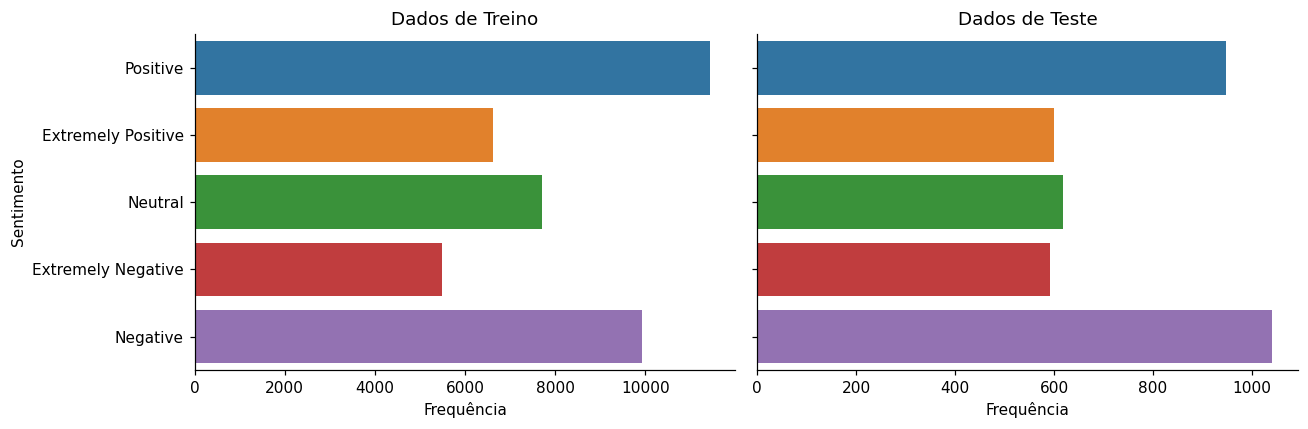

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, dpi=110)

order = ['Positive', 'Extremely Positive', 'Neutral', 'Extremely Negative', 'Negative']

sns.countplot(y='Sentiment', data=train_data, order=order, ax=ax[0])
ax[0].set(xlabel='Frequência', ylabel='Sentimento', title='Dados de Treino')

sns.countplot(y='Sentiment', data=test_data, order=order, ax=ax[1])
ax[1].set(xlabel='Frequência', ylabel=None, title='Dados de Teste')

sns.despine()
plt.tight_layout();


## Pre-processamento de texto

In [7]:
### Tentamos deixar tudo que pode ser realizado fora da função a fim de otimizarmos o código
# Expressões regulares
remove_urls     = re.compile(r'https?://\S+|www\.\S+')
remove_hashtags = re.compile(r'#')
remove_emails   = re.compile(r'\S+@\S+')
remove_rt       = re.compile(r'^RT[\s]+')
remove_numbers  = re.compile(r'\d+')

# Carrega "stopwords" da bliblioteca NLTK
stop_words  = stopwords.words('english')

# Carrega a pontuação
punctuation = string.punctuation

# Instancia o TweetTokenizer
tknzr = TweetTokenizer(preserve_case=False,  # transforma em minúsculas
                       strip_handles=True,   # remove citaçãoes
                       reduce_len=True)      # reduz caracteres repetidos

def preprocess_text(text):


    # Apply regex
    text = remove_urls.sub('', text)        # remove urls

    # Parse HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # text = remove_hashtags.sub('', text)  # remove hashtags    

    text = remove_emails.sub('', text)      # remove emails

    text = remove_rt.sub('', text)          # remove RT
    
    text = remove_numbers.sub('', text)     # remove números

    # Tokenização
    tokens = tknzr.tokenize(text)

    # Remove pontuação
    tokens = [word for word in tokens if word not in punctuation] 
    
    # Remove stop words    
    tokens = [word for word in tokens if word not in stop_words]

    # Remove no alphabetical and single chars
    tokens = [word for word in tokens if word.isalpha()] # and len(word) > 1]

    ### SpaCy ###
    ## Lemmatization
    # text = ' '.join(tokens)
    # doc = nlp(text)
    
    # tokens = [token.lemma_ for token in doc if token.lemma_ not in portuguese_stop_words]
    
    return ' '.join(tokens)

In [8]:
%%time
# Pré-processa a base de treino
train_data['tweet'] = train_data['OriginalTweet'].apply(preprocess_text)

# Pré-processa a base de teste
test_data['tweet'] = test_data['OriginalTweet'].apply(preprocess_text)

Wall time: 18.3 s


In [9]:
# Cria coluna com a quantidade de palavras nas células pré-processadas: base de treino
train_data['word_count'] = train_data['tweet'].apply(lambda text: len(text.split()))

# Cria coluna com a quantidade de palavras nas células pré-processadas: base de teste
test_data['word_count'] = test_data['tweet'].apply(lambda text: len(text.split()))

In [10]:
train_data.head()

,OriginalTweet,Sentiment,tweet,word_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,,0
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order,27
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak,12
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,food stock one empty please panic enough food everyone take need stay calm stay safe,15
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative,ready go supermarket outbreak paranoid food stock litteraly empty serious thing please panic causes shortage,15


## Tratamento de dados faltantes após o pré-processamento

In [11]:
# Substitui as colunas vazias por "NaN": base de treino
train_data.loc[train_data['word_count'] == 0, ['tweet']]= np.nan

# Substitui as colunas vazias por "NaN": base de teste
test_data.loc[test_data['word_count'] == 0, ['tweet']]= np.nan

In [12]:
# Verifica se há dados faltantes na base de treino
train_data.isna().sum()

OriginalTweet     0
Sentiment         0
tweet            54
word_count        0
dtype: int64

In [13]:
# Verifica se há dados faltantes na base de teste
test_data.isna().sum()

OriginalTweet    0
Sentiment        0
tweet            3
word_count       0
dtype: int64

In [14]:
# Remove os dados faltantes da base de treino
train_data.dropna(inplace=True)

# Remove os dados faltantes da base de teste
test_data.dropna(inplace=True)

In [15]:
# Sanity check
print('Base de treino', '---', train_data.isna().sum(), '\nBase de teste', '---', train_data.isna().sum(), sep='\n')

Base de treino
---
OriginalTweet    0
Sentiment        0
tweet            0
word_count       0
dtype: int64

Base de teste
---
OriginalTweet    0
Sentiment        0
tweet            0
word_count       0
dtype: int64


In [16]:
train_data = train_data[['tweet', 'word_count', 'Sentiment']].copy()
test_data  = test_data[['tweet', 'word_count', 'Sentiment']].copy()

In [17]:
train_data.head()

,tweet,word_count,Sentiment
1,advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order,27,Positive
2,coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak,12,Positive
3,food stock one empty please panic enough food everyone take need stay calm stay safe,15,Positive
4,ready go supermarket outbreak paranoid food stock litteraly empty serious thing please panic causes shortage,15,Extremely Negative
5,news regionâ first confirmed covid case came sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper goods reports,25,Positive


In [18]:
test_data.head()

,tweet,word_count,Sentiment
0,trending new yorkers encounter empty supermarket shelves pictured wegmans brooklyn online grocers foodkick maxdelivery shoppers stock,16,Extremely Negative
1,find hand sanitizer fred meyer turned pack purell check concerns driving prices,12,Positive
2,find protect loved ones,4,Extremely Positive
3,buying hits city anxious shoppers stock food medical supplies worker becomes st confirmed patient staged event,16,Negative
4,one week everyone buying baby milk powder next everyone buying toilet paper,12,Neutral


### Gráfico da distribuição de frequência da quantidade de palavras utilizadas por tweet

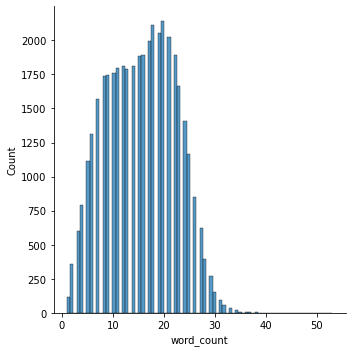

In [19]:
sns.displot(x='word_count', data=train_data);

## Preparação dos dados para o modelo

In [20]:
# Cria um índice de palavras utilizando a base de treino
tokenizer = Tokenizer(oov_token='<UNK>')
tokenizer.fit_on_texts(train_data['tweet'])

In [21]:
# Armazena a quantidade de índices criados
vocab_size = len(tokenizer.word_index) + 1 # O "+1" se refere ao índice 0 (zero) que será criado na etapa de seguinte
vocab_size

33156

In [22]:
# Transforma os textos em sequência de vetores de mesmo tamanho
X_train_seq = tokenizer.texts_to_sequences(train_data['tweet'])
X_train =  pad_sequences(X_train_seq,
                         maxlen=30,          # tamanho máximo dos vetores - escolhido de acordo com a distribuição 
                                             # de frquência de palabras utilizadas nos tweets
                         padding='post',     # vetores menores que o "maxlen" serão preenchidos com 0 (zeros)
                                             # ao final    
                         truncating='post')  # vetores maiores que o "maxlen" serão truncados ao final


# Realiza o mesmo procedimento para os dados de teste
X_test_seq = tokenizer.texts_to_sequences(test_data['tweet'])
X_test = pad_sequences(X_test_seq, maxlen=30, padding='post', truncating='post')

In [23]:
print(X_train[:5])

[[  378   725  2356   167  2564   709  1070   929   320   266   709  1070
   2356  1061  3315  3071  4322   360    12    11  2105 17492  2850   101
    886  2721   137     0     0     0]
 [   25   808  4152   203   213  1284  1626    11   165    77     2    62
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [    4    28    30   127    34    17   146     4    66    56    14    41
    809    41    82     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  594    21     6    62  3737     4    28 17493   127   670   198    34
     17  1500   325     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  119 13059    97  1009     2   453   604 13060   710   102    74     8
   9414   464    48   517   515   101    27    24     4    38    39   182
    330     0     0     0     0     0]]


In [24]:
# Transformação das classes da variável alvo em dados numéricos
le = LabelEncoder()
y_train = le.fit_transform(train_data['Sentiment'])  # treino
y_test  = le.fit_transform(test_data['Sentiment'])   # teste

# armazena o nome dos atributos e classe
target_names = le.classes_

print(y_train)


[4 4 4 ... 4 3 2]


In [25]:
# Sanity check
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((41103, 30), (41103,), (3795, 30), (3795,))

## Treinamento e validação do modelo

In [26]:
# Fixa uma semente para reproducibilidade do modelo
np.random.seed(0)
tf.random.set_seed(0)
tf.keras.backend.clear_session()

# Modelo
model = tf.keras.Sequential([

        # Cria a dimensão com os vetores de palavras
        tf.keras.layers.Embedding(vocab_size, output_dim=100, input_length=X_train.shape[1]),

        # LSTM bidirecional
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3)),

        # Camada final para as cinco categorias que se deseja prever
        tf.keras.layers.Dense(5, activation='softmax')
])

# Compila o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',  # utilizado quando não se usa "one-hot-encoder"  
                                                       # para transformar a variável alvo 
              metrics=['accuracy'])

# Exibe um sumário do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           3315600   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
Total params: 3,477,405
Trainable params: 3,477,405
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train,
                    y_train,
                    batch_size=64,
                    epochs=30,
                    validation_split=0.2, # divide a base de treino em 80% dos dados para treino
                                          # e 20% para validação                                           #                                           
                    workers=4,
                    use_multiprocessing=True)

Train on 32882 samples, validate on 8221 samples
Epoch 1/30
32882/32882 [==============================] - 70s 2ms/sample - loss: 1.1607 - accuracy: 0.5082 - val_loss: 0.7818 - val_accuracy: 0.7092
Epoch 2/30
32882/32882 [==============================] - 63s 2ms/sample - loss: 0.6664 - accuracy: 0.7605 - val_loss: 0.6664 - val_accuracy: 0.7641
Epoch 3/30
32882/32882 [==============================] - 64s 2ms/sample - loss: 0.4793 - accuracy: 0.8394 - val_loss: 0.6942 - val_accuracy: 0.7542
Epoch 4/30
32882/32882 [==============================] - 66s 2ms/sample - loss: 0.3728 - accuracy: 0.8776 - val_loss: 0.7302 - val_accuracy: 0.7579
Epoch 5/30
32882/32882 [==============================] - 66s 2ms/sample - loss: 0.2944 - accuracy: 0.9050 - val_loss: 0.8278 - val_accuracy: 0.7402
Epoch 6/30
32882/32882 [==============================] - 65s 2ms/sample - loss: 0.2426 - accuracy: 0.9219 - val_loss: 0.9119 - val_accuracy: 0.7386
Epoch 7/30
32882/32882 [==============================] -

In [28]:
hist = pd.DataFrame(history.history)
hist.head(3)

,loss,accuracy,val_loss,val_accuracy
0,1.160660,0.508242,0.781778,0.709159
1,0.666394,0.760477,0.666404,0.764141
2,0.479265,0.839395,0.694229,0.754166


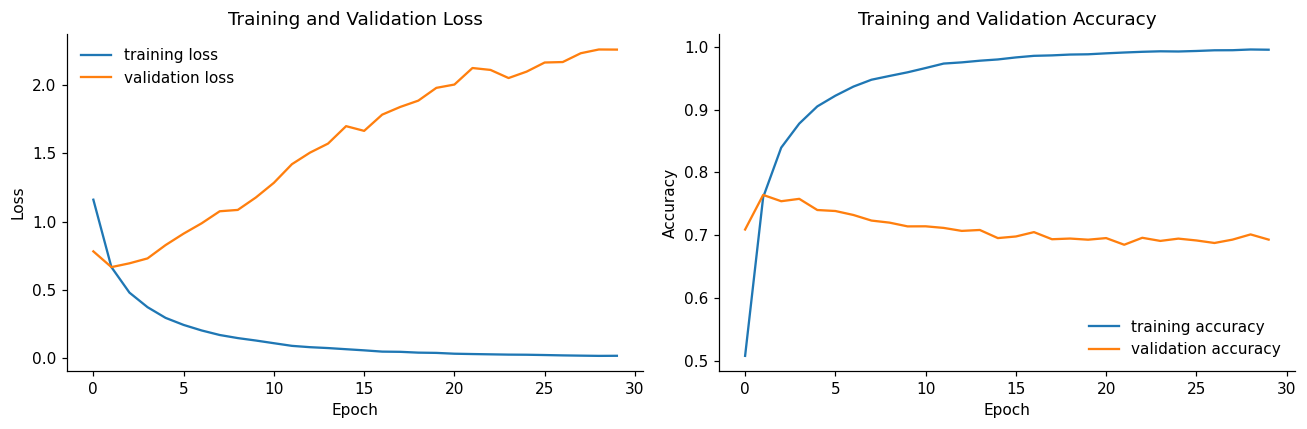

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=110)
ax = ax.ravel()

metrics = ['loss', 'accuracy']

for i, metric in enumerate(metrics):
    sns.lineplot(x=hist.index, y=f'{metric}', data=hist, ax=ax[i], label=f'training {metric}')
    sns.lineplot(x=hist.index, y=f'val_{metric}', data=hist, ax=ax[i], label=f'validation {metric}')
    ax[i].set(xlabel='Epoch', ylabel=f'{metric.title()}', title=f'Training and Validation {metric.title()}')
    ax[i].legend(frameon=False)

sns.despine()
plt.tight_layout();

## Testing 

In [30]:
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Acurácia do modelo sobre os dados de teste: {accuracy:.3%}')

Acurácia do modelo sobre os dados de teste: 66.298%


In [31]:
# Predictions
preds = np.argmax(model.predict(X_test), axis=1)

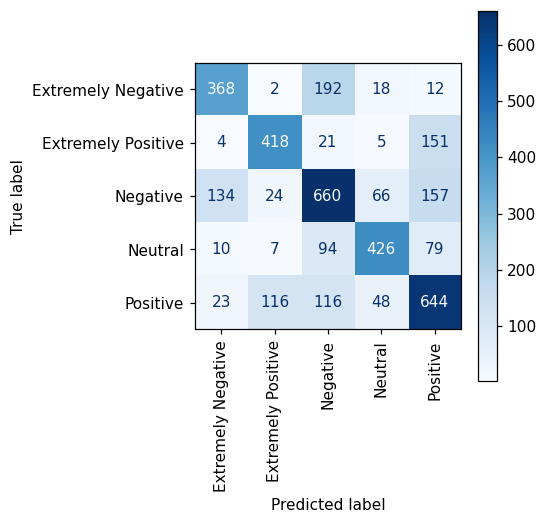

In [32]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=110) # 

cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=target_names).plot(cmap='Blues', xticks_rotation='vertical', ax=ax)
plt.tight_layout();

In [33]:
print(classification_report(y_test, preds, target_names=target_names))

                    precision    recall  f1-score   support

Extremely Negative       0.68      0.62      0.65       592
Extremely Positive       0.74      0.70      0.72       599
          Negative       0.61      0.63      0.62      1041
           Neutral       0.76      0.69      0.72       616
          Positive       0.62      0.68      0.65       947

          accuracy                           0.66      3795
         macro avg       0.68      0.67      0.67      3795
      weighted avg       0.67      0.66      0.66      3795

